In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from scipy import stats
from sklearn.linear_model import LinearRegression

# python display
from IPython.display import HTML, display_html, display

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from prepare import *

In [2]:
df, revert_key, replace_key  = wrangle_data()

In [3]:
df.head()

,qkey,device_type,language,form,attitude,avg_family,happen_general,happen_health,happen_race,happen_usa,...,family_income_three_categories,registered_to_vote,political_views,internet_access,volunteer,weight,is_pes,pes_val,is_very_pes,is_very_opt
0,100363,Mobile phone,English,Form 1,Somewhat optimistic,Get worse,The U.S. economy will be STRONGER,Health care will be MORE affordable,Race relations will IMPROVE,The U.S. will be MORE important in the world,...,"$75,000+",You are ABSOLUTELY CERTAIN that you are regist...,Liberal,Internet User,No,0.599006,0,1,0,0
1,101224,Mobile phone,English,Form 1,Somewhat optimistic,Get better,The U.S. economy will be STRONGER,Health care will be LESS affordable,Race relations will IMPROVE,The U.S. will be MORE important in the world,...,"$30-$74,999",You are ABSOLUTELY CERTAIN that you are regist...,Conservative,Internet User,Yes,0.292981,0,1,0,0
2,101437,Desktop,English,Form 1,Somewhat pessimistic,Get worse,The U.S. economy will be WEAKER,Health care will be LESS affordable,Race relations will GET WORSE,The U.S. will be LESS important in the world,...,"<$30,000",You are ABSOLUTELY CERTAIN that you are regist...,Conservative,Internet User,No,0.418871,1,2,0,0
3,102130,Mobile phone,English,Form 1,Somewhat optimistic,Stay about the same,The U.S. economy will be WEAKER,Health care will be LESS affordable,Race relations will IMPROVE,The U.S. will be LESS important in the world,...,Don't know/Refused,You are ABSOLUTELY CERTAIN that you are regist...,Moderate,Non Internet User,Yes,0.342058,0,1,0,0
4,103094,Mobile phone,English,Form 1,Somewhat optimistic,Stay about the same,Refused,Health care will be LESS affordable,Refused,The U.S. will be LESS important in the world,...,"<$30,000",You are NOT registered to vote at your current...,Liberal,Internet User,Yes,0.329465,0,1,0,0


In [4]:
class Attitudes_explore():
    '''
    Performs a series of analyses and explore functions on various features in our data.
    '''
    
    def __init__(self, df: pd.DataFrame, target: str, subset_title: str):
        '''
        Initializes the self of the class.
        '''
        self.target = target
        
        self.subset_title = subset_title
        
        # Pull the categorical features from dataframe
        try: 
            self.categorical_features = df.drop(columns = ['qkey', "weight", target]).columns.to_list()
        except:
            self.categorical_features = df.drop(columns= [target]).columns.to_list()
        
        # Split the dataframe
        train, validate, test = train_validate_test_split(df, target)
        
        # Make train datasets
        self.X_train = train.drop(columns=[target])
        self.y_train = train[target]
        
        # Make validate datasets
        self.X_validate = validate.drop(columns=[target])
        self.y_validate = validate[target]
        
        # Make test datasets
        self.X_test = test.drop(columns=[target])
        self.y_test = test[target]
        
        
        #Make dummies 
        df_dummies = pd.get_dummies(df, drop_first = True)
        
        #Split the dummies dataframe
        train_dummies, validate_dummies, test_dummies = train_validate_test_split(df_dummies, target)

        # Make train_dummies datasets
        self.X_train_dummies = train_dummies.drop(columns=[target])
        self.y_train_dummies = train_dummies[target]
        
        # Make validate_dummies datasets
        self.X_validate_dummies = validate_dummies.drop(columns=[target])
        self.y_validate_dummies = validate_dummies[target]
        
        # Make test_dummies datasets
        self.X_test_dummies = test_dummies.drop(columns=[target])
        self.y_test_dummies = test_dummies[target]
        
        
        
        
    def run_statistical_tests(self):
        '''This method will iterate though the categorical feature columns and run various statistical tests
        and will print the results for each test.
        The tests being performed are:
        chi_squared
        significant_p_val
        list_significant_columns
        insignificant_p_val
        list_insignificant_columns
        '''
        
        # Create column_based_dict statistic attributes
        self.chi2_df = pd.DataFrame(columns=['chi2', 'p_val', 'deg_free', 'expected_freq'])
        
        # Iterate through the categorical features
        for col in self.categorical_features:
            
            #Create contingency table
            contingency_table = pd.crosstab(self.X_train[col], self.y_train)
            
            #Get test results of chi-squared test
            chi2, p, deg_free, expect_freq = stats.chi2_contingency(contingency_table)
            # Add to the dataframe
            self.chi2_df.loc[col]= [chi2, p, deg_free, expect_freq]
    
    def plot_bar_graphs(self, n=5, saved=False):
        '''Plots the target and each variable for top 'n' results from the chi2 test
        '''
        display(HTML(f'''<html><h1>{self.subset_title}</h1></html>'''))
        # Select the n most relevant p_vals
        
        for col in self.chi2_df.head(n).index:
            plt.figure(figsize=(10, 5))
            sns.barplot(x= self.y_train, y = self.X_train[col]).set_title(
                label=f'{self.target.title()} vs {col.title()} Barplot')
            plt.xticks(rotation = 90, horizontalalignment='right', fontsize = 12)
            if saved:
                plt.savefig(f"images/{self.subset_title.replace(' ', '_').lower()}{col.lower()}_bar_plot.png")
            plt.show()
            
    def countplots(self, n=5, saved=False):
        '''Runs the countplot method from Seaborn on the top n=5 (in terms of lowest p-val) columns
        from the dataset, and then shows the plots. If the 'saved' flag is True, it will save the plts to the images
        folder to be read into the README.
        '''
        HTML(f'''<html><h1><center>{self.subset_title}</h1></center></html>''')
    

In [5]:
def generate_and_return_obj(df: pd.DataFrame):
    # This will drop the columns that you don't want to target yet
    tmp = df[[col for col in df.columns if col not in [
        'pes_val', 'is_very_pes', 'is_very_opt', 'attitude', 'avg_family']]]

    # Create instance
    o = Attitudes_explore(tmp, target='is_pes', subset_title = 'Whole dataset with top 5 lowest p-vals')

    # Create accessable dict results
    o.run_statistical_tests()
    # Return the object that was created with the statistical tests being run
    return o
    

In [6]:
o = generate_and_return_obj(df)

In [7]:
o.X_train_dummies

,qkey,weight,device_type_Mobile phone,device_type_Tablet,language_Spanish,form_Form 2,happen_general_The U.S. economy will be STRONGER,happen_general_The U.S. economy will be WEAKER,happen_health_Health care will be MORE affordable,happen_health_Refused,...,registered_to_vote_You are NOT registered to vote at your current address,"registered_to_vote_You are PROBABLY registered, but there is a chance your registration has lapsed",political_views_Liberal,political_views_Moderate,political_views_Refused,political_views_Very conservative,political_views_Very liberal,internet_access_Non Internet User,volunteer_Refused,volunteer_Yes
1859,201801113305,3.057078,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
96,191336,0.433484,0,0,0,1,0,1,0,1,...,0,1,1,0,0,0,0,0,0,0
420,668019,2.413983,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1424,201801054651,0.362586,1,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
114,200943,0.303046,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,201501605240,2.336849,0,1,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
957,201701615366,0.553714,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
239,333639,1.368277,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1795,201801105856,1.338218,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Now we will begin building our functions for modeling

In [8]:
def test_a_model(X_train, y_train, X_validate, y_validate, model, model_name, score_df):
    '''
    Function takes in X and y train
    X and y validate (or test) 
    A model with it's hyper parameters
    And a df to store the scores 
    - Set up an empty dataframe with score_df first
    - score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])
    '''
    this_model = model

    this_model.fit(X_train, y_train)

    # Check with Validate

    train_score = this_model.score(X_train, y_train)
    
    validate_score = this_model.score(X_validate, y_validate)
    
    model_dict = {'model_name': model_name, 
                  'train_score': train_score, 
                  'validate_score':validate_score}
    score_df = score_df.append(model_dict, ignore_index = True)
    
    return score_df

########### Evaluation metrics printing function

def print_metrics(model, X, y, pred, class_names, set_name = 'This Set'):
    '''
    This function takes in a model, 
    X dataframe
    y dataframe 
    predictions 
    Class_names (aka ['Java', 'Javascript', 'Jupyter Notebook', 'PHP'])
    and a set name (aka train, validate or test)
    Prints out a classification report 
    and confusion matrix as a heatmap
    To customize colors change insdie the function
    - IMPORTANT change lables inside this function
    '''
    
    
    print(model)
    print(f"~~~~~~~~{set_name} Scores~~~~~~~~~")
    print(classification_report(y, pred))
    
    #purple_cmap = sns.cubehelix_palette(as_cmap=True)
    purple_cmap = sns.color_palette("light:indigo", as_cmap=True)
    
    with sns.axes_style("white"):
        matrix = plot_confusion_matrix(model,X, y, display_labels=class_names, 
                                       cmap = purple_cmap)
        plt.grid(False)
        plt.show()
        print()


######### This function makes models and prints metrics (uses above function)
#### can run in a loop to loop through models 

def make_models_and_print_metrics(model, model_name, X_train, y_train, X_validate, y_validate, class_names):
    '''
    This function takes in a model object,
    Name for the model (for vis purposes)
    X_train, y_train
    X_validate and y_validate
    and the names of your classes (aka category names)
    Uses print metrics function 
    '''
    model.fit(X_train, y_train)

    #predict for train and validate
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_validate)
    
    print(f'                   ============== {model_name} ================           ')
    #see metrics for train
    print_metrics(model, X_train, y_train, train_pred, class_names, set_name='Train')
    #print metrics for validate
    print_metrics(model, X_validate, y_validate, val_pred, class_names, set_name='Validate')
    print('-------------------------------------------------------------------\n')


######### Function for evaluating the final Test data ################ 

def make_models_and_print_metrics_test_data(model, model_name, X_train, y_train, X_test, y_test, class_names):
    '''
    This function takes in a model object,
    Name for the model (for vis purposes)
    and the names of your classes (aka category names)
    Uses print metrics function 
    Use this function on the final test data set. 
    '''
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    
    print(f'                   ============== {model_name} ================           ')
    #print metrics for Test
    print_metrics(model, X_test, y_test, test_pred, class_names, set_name='Test')
    print('------------------------------------')

## DataFrame for Storing the Results of the Models

In [81]:
# create dataframe to store the scores
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

## Get Baseline Accuracy

In [82]:
#PHP is the baseline prediction
print(f'Baseline Accuracy: {(1.00 - round(o.y_train_dummies.mean(), 4))* 100}%')

Baseline Accuracy: 55.75%


## Import Models and Get Model List

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

In [84]:
# create list of models to loop through
tree_list = []

for i in range(3, 10):
    tree_list.append(DecisionTreeClassifier(max_depth = i, random_state = 123))

tree_model_name_list = []

# create list of model names that correspond to models
for i in range(3, 10):
    model_name_list.append(f"decision_tree_depth_{i}")


In [85]:
#Append results to score_df
for model, name in zip(tree_list, model_name_list):
    score_df = test_a_model(o.X_train_dummies, o.y_train_dummies, o.X_validate_dummies, o.y_validate_dummies, model, name, score_df)

In [86]:
score_df

,model_name,train_score,validate_score
0,decision_tree_depth_3,0.750710,0.731788
1,decision_tree_depth_4,0.778409,0.730132
2,decision_tree_depth_5,0.794744,0.738411
3,decision_tree_depth_6,0.838068,0.708609
4,decision_tree_depth_7,0.882102,0.711921
5,decision_tree_depth_8,0.923295,0.675497
6,decision_tree_depth_9,0.946733,0.670530


In [87]:
forest_list = []

for i in range(3, 10):
    for j in range(1, 10):
        forest_list.append(RandomForestClassifier(min_samples_leaf = i, max_depth = j))

        
forest_name_list = []
for i in range(3, 10):
    for j in range(0, 10):
        forest_name_list.append(f"random_forest_min_samples_leaf_{i}_depth_{j}")
                

In [88]:
#Append results to score_df
for model, name in zip(forest_list, forest_name_list):
    score_df = test_a_model(o.X_train_dummies, o.y_train_dummies, o.X_validate_dummies, o.y_validate_dummies, model, name, score_df)

In [90]:
score_df.sort_values(by = 'validate_score', ascending = False)

,model_name,train_score,validate_score
59,random_forest_min_samples_leaf_8_depth_2,0.848011,0.794702
28,random_forest_min_samples_leaf_5_depth_1,0.787642,0.791391
47,random_forest_min_samples_leaf_7_depth_0,0.803267,0.791391
24,random_forest_min_samples_leaf_4_depth_7,0.897727,0.789735
21,random_forest_min_samples_leaf_4_depth_4,0.838068,0.789735
...,...,...,...
4,decision_tree_depth_7,0.882102,0.711921
3,decision_tree_depth_6,0.838068,0.708609
25,random_forest_min_samples_leaf_4_depth_8,0.699574,0.687086
5,decision_tree_depth_8,0.923295,0.675497


In [91]:
k_neighbors_list = []

for i in range(5, 12):
    k_neighbors_list.append(KNeighborsClassifier(n_neighbors = i, weights = 'uniform'))

k_names_list = []
for i in range(5, 12):
    k_names_list.append(f"k_nearest_neighbors_{i}")

In [92]:
#Append results to score_df
for model, name in zip(k_neighbors_list, k_names_list):
    score_df = test_a_model(o.X_train_dummies, o.y_train_dummies, o.X_validate_dummies, o.y_validate_dummies, model, name, score_df)

In [95]:
score_df.sort_values(by = "validate_score", ascending = False)

,model_name,train_score,validate_score
59,random_forest_min_samples_leaf_8_depth_2,0.848011,0.794702
28,random_forest_min_samples_leaf_5_depth_1,0.787642,0.791391
47,random_forest_min_samples_leaf_7_depth_0,0.803267,0.791391
21,random_forest_min_samples_leaf_4_depth_4,0.838068,0.789735
57,random_forest_min_samples_leaf_8_depth_0,0.815341,0.789735
...,...,...,...
74,k_nearest_neighbors_9,0.602983,0.521523
70,k_nearest_neighbors_5,0.629972,0.509934
73,k_nearest_neighbors_8,0.612216,0.508278
72,k_nearest_neighbors_7,0.623580,0.503311


In [98]:
extra_models_list = [LinearSVC(), LogisticRegression(), MultinomialNB()]

extra_model_names = ['linear_svc', 'logistic_regression', 'naive_bayes']

In [99]:
#Append results to score_df
for model, name in zip(extra_models_list, extra_model_names):
    score_df = test_a_model(o.X_train_dummies, o.y_train_dummies, o.X_validate_dummies, o.y_validate_dummies, model, name, score_df)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [101]:
score_df.sort_values(by = "validate_score", ascending = False)

,model_name,train_score,validate_score
59,random_forest_min_samples_leaf_8_depth_2,0.848011,0.794702
28,random_forest_min_samples_leaf_5_depth_1,0.787642,0.791391
47,random_forest_min_samples_leaf_7_depth_0,0.803267,0.791391
24,random_forest_min_samples_leaf_4_depth_7,0.897727,0.789735
57,random_forest_min_samples_leaf_8_depth_0,0.815341,0.789735
...,...,...,...
74,k_nearest_neighbors_9,0.602983,0.521523
70,k_nearest_neighbors_5,0.629972,0.509934
73,k_nearest_neighbors_8,0.612216,0.508278
72,k_nearest_neighbors_7,0.623580,0.503311


## Feature Importances

In [106]:
rf_depth_2_leaf_8 = RandomForestClassifier(min_samples_leaf =8, max_depth =2)
rf_depth_2_leaf_8.fit(o.X_train_dummies, o.y_train_dummies)


RandomForestClassifier(max_depth=2, min_samples_leaf=8)

In [111]:
#Create data frame of feature importances, using our selected model
feature_importances = pd.DataFrame(rf_depth_2_leaf_8.feature_importances_, index = o.X_train_dummies.columns, columns = [ "relative importance"])
#Sort the data frame by the relative importance of each feature
feature_importances = feature_importances.sort_values(by = ['relative importance'], ascending = False)
#Rename the index column "category"
feature_importances.columns.names = ['category']
#Display DataFrame
feature_importances.head(40)

category,relative importance
happen_usa_The U.S. will be LESS important in the world,0.097070
happen_pub_ed_The public education system will IMPROVE,0.093429
happen_general_The U.S. economy will be WEAKER,0.076746
happen_pub_ed_The public education system will GET WORSE,0.070998
happen_general_The U.S. economy will be STRONGER,0.067033
happen_child_f2_Children will have a WORSE standard of living,0.051758
happen_race_Race relations will IMPROVE,0.041415
share_americans_in_lower_class_Increase,0.038235
happen_usa_The U.S. will be MORE important in the world,0.034651
happen_politics_The country will be LESS politically divided,0.030163


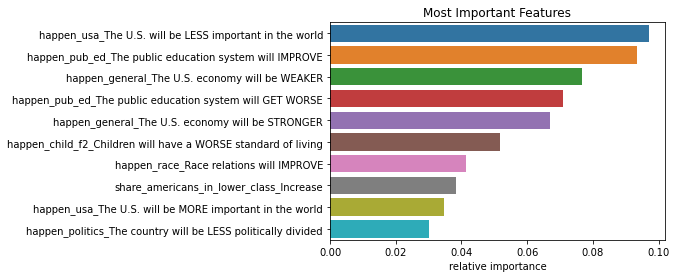

In [114]:
relative_importances = sns.barplot(x=feature_importances['relative importance'][0:10], y=feature_importances.index[0:10]).set(title="Most Important Features")

## Run Model on Test

In [116]:
test_predictions = rf_depth_2_leaf_8.predict(o.X_test_dummies)

In [118]:
classification_report_test = pd.DataFrame(classification_report(o.y_test_dummies, test_predictions, output_dict = True)).T
classification_report_test

,precision,recall,f1-score,support
0,0.742138,0.839858,0.787980,281.000000
1,0.756757,0.630631,0.687961,222.000000
accuracy,0.747515,0.747515,0.747515,0.747515
macro avg,0.749448,0.735244,0.737970,503.000000
weighted avg,0.748590,0.747515,0.743836,503.000000


Our best performing model is 75% acurate on the test data. 